In [133]:
# importing the different libraries 
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#importing the different algorithms
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings("ignore")

#defining the function for MDA
def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]


# Step 1. Load data

We will select only sales data for now, and will use only the columns "Order Date" and "Sales".

In [95]:
#Load the data
df = pd.read_excel("Data final new.xlsx", usecols=["Date", "Sales","Quantity","Traffic"])

In [96]:
#display the first few cells
df.head()

,Date,Sales,Quantity,Traffic
0,2019-11-01,0.00,0,46
1,2019-11-01,0.00,0,48
2,2019-11-01,79.99,1,28
3,2019-11-01,778.92,8,87
4,2019-11-01,85.99,1,25


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913 entries, 0 to 10912
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      10913 non-null  datetime64[ns]
 1   Sales     10913 non-null  float64       
 2   Quantity  10913 non-null  int64         
 3   Traffic   10913 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 341.2 KB


In [98]:
df.shape

(10913, 4)

In [99]:
# change datatype of Date columns.
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [100]:
df.head()

,Date,Sales,Quantity,Traffic
0,2019-11-01,0.00,0,46
1,2019-11-01,0.00,0,48
2,2019-11-01,79.99,1,28
3,2019-11-01,778.92,8,87
4,2019-11-01,85.99,1,25


In [101]:
df.shape

(10913, 4)

In [102]:
df.head()

,Date,Sales,Quantity,Traffic
0,2019-11-01,0.00,0,46
1,2019-11-01,0.00,0,48
2,2019-11-01,79.99,1,28
3,2019-11-01,778.92,8,87
4,2019-11-01,85.99,1,25


In [103]:
df.isnull().sum()

Date        0
Sales       0
Quantity    0
Traffic     0
dtype: int64

In [104]:
# summary statistics
df.describe()

,Sales,Quantity,Traffic
count,10913.000000,10913.000000,10913.000000
mean,772.455637,8.304957,108.900852
std,1170.215087,10.826694,127.153764
min,0.000000,0.000000,0.000000
25%,105.040000,2.000000,32.000000
50%,281.960000,4.000000,65.000000
75%,880.000000,10.000000,123.000000
max,13911.256757,117.000000,741.000000


In [105]:
df['YearMonth'] = df['Date'].apply(lambda x: x.strftime("%Y-%m"))
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month_name()


In [106]:
# create a column for days of week.
df['day_of_week'] = df.Date.dt.weekday

In [107]:
df.head()

,Date,Sales,Quantity,Traffic,YearMonth,year,month,day_of_week
0,2019-11-01,0.00,0,46,2019-11,2019,November,4
1,2019-11-01,0.00,0,48,2019-11,2019,November,4
2,2019-11-01,79.99,1,28,2019-11,2019,November,4
3,2019-11-01,778.92,8,87,2019-11,2019,November,4
4,2019-11-01,85.99,1,25,2019-11,2019,November,4


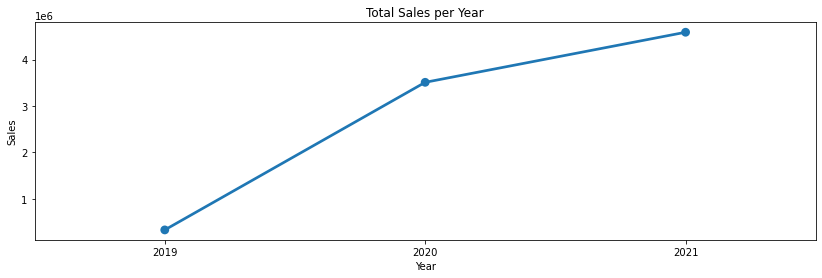

In [108]:
# Let's examine Sales over time.
a = pd.DataFrame(df.groupby(by=['year']).sum())

plt.figure(figsize=(14, 4))
sns.pointplot(x=a.index, y='Sales', data=a)

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title("Total Sales per Year")

plt.show()

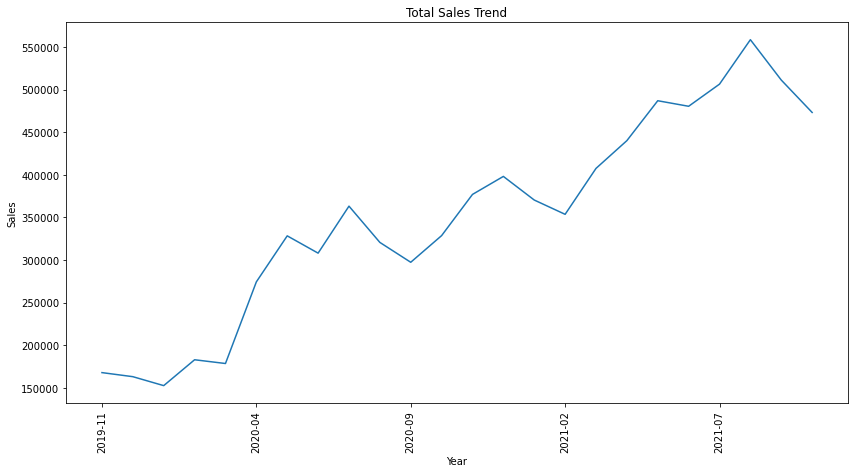

In [109]:
# Year-to-Year observation of TotalSales.
a = pd.DataFrame(df.groupby(by=['YearMonth']).sum())['Sales']

plt.figure(figsize=(14, 7))
a.plot(kind='line')

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title("Total Sales Trend")

plt.xticks(rotation=90)
plt.show()

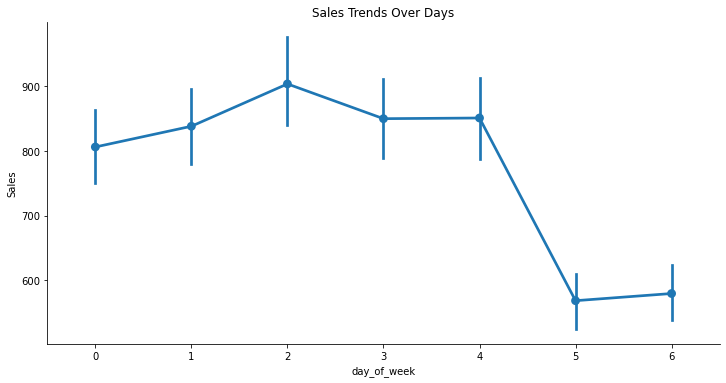

In [110]:
# Sales trends over days.
sns.catplot(data=df, x='day_of_week', y='Sales', kind='point', aspect=2)

plt.title("Sales Trends Over Days")
plt.show()

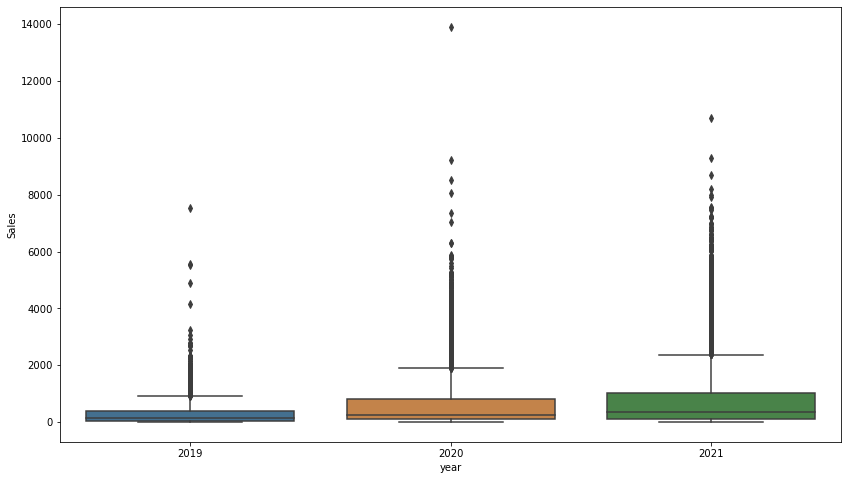

In [111]:
# check for outliers in Sales.
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='year', y='Sales', saturation=0.5)
plt.show()

In [112]:
df.set_index("Date", inplace=True)

In [113]:
df.index.min(), df.index.max()

(Timestamp('2019-11-01 00:00:00'), Timestamp('2021-10-31 00:00:00'))

In [114]:
# Obtain daily amounts of sales
df = df.groupby('Date').sum()

In [115]:
df.shape

(731, 5)

# Step 2. Train-test split

We will use random sampling, as there is no independent variable to control for.

In [116]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

584 train and 147 test instances


In [117]:
train_set

,Sales,Quantity,Traffic,year,day_of_week
Date,,,,,
2019-11-01,3306.580000,42,547,26247,52
2019-11-02,2633.670000,33,544,26247,65
2019-11-03,3704.530000,47,595,26247,78
2019-11-04,3778.500000,50,579,26247,0
2019-11-05,4655.380000,62,747,26247,13
...,...,...,...,...,...
2021-06-02,16659.047349,153,1649,36378,36
2021-06-03,16079.433959,162,1748,36378,54
2021-06-04,16324.292400,162,1738,34357,68


In [118]:
test_set

,Sales,Quantity,Traffic,year,day_of_week
Date,,,,,
2021-06-07,13608.529851,134,2051,34357,0
2021-06-08,15858.923954,145,1958,36378,18
2021-06-09,16905.819015,165,1964,36378,36
2021-06-10,16699.796355,170,1958,32336,48
2021-06-11,17099.059880,162,1823,36378,72
...,...,...,...,...,...
2021-10-27,20596.153425,182,2063,34357,34
2021-10-28,19354.039082,174,1870,30315,45
2021-10-29,20683.751913,174,1629,34357,68


# Step 3. Exploratory Data Analysis

Plot the data.

<AxesSubplot:xlabel='Date'>

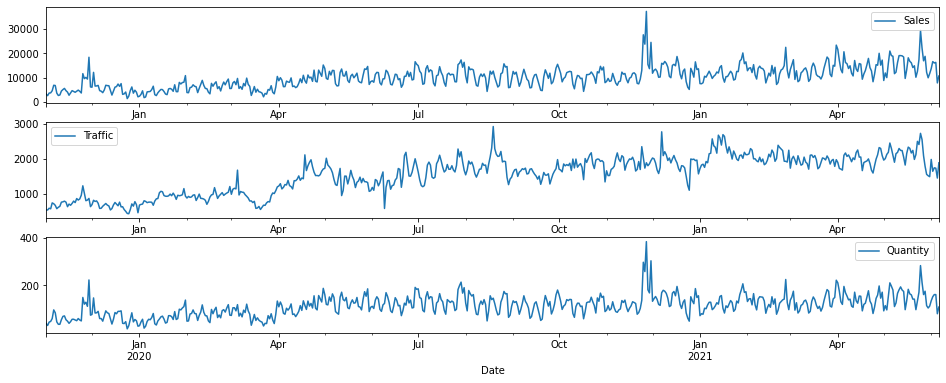

In [119]:
plt.subplot(311)
train_set['Sales'].plot(figsize=(16, 6), legend=True)
plt.subplot(312)
train_set['Traffic'].plot(figsize=(16, 6), legend=True)
plt.subplot(313)
train_set['Quantity'].plot(figsize=(16, 6), legend=True)

# Time series decomposition

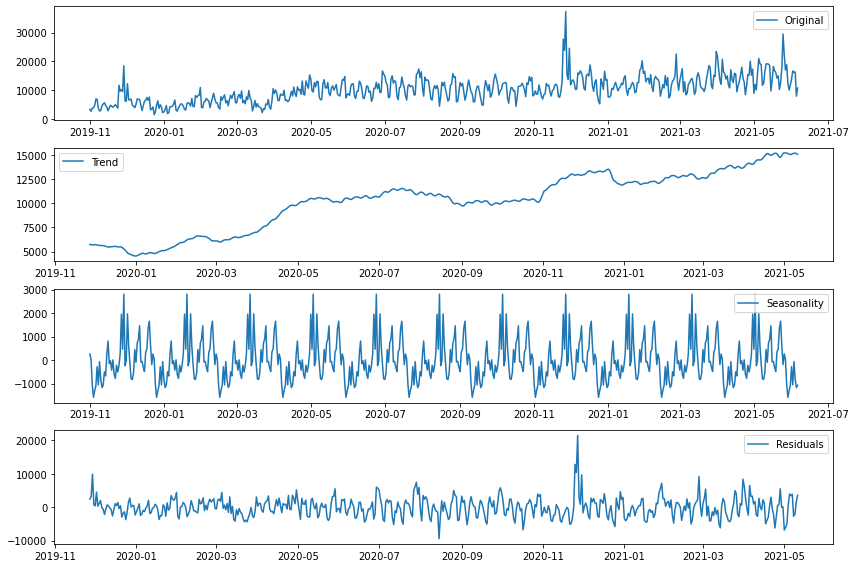

In [121]:
from statsmodels.tsa.seasonal import seasonal_decompose

# specify the number of observations in a cycle
decomposition = seasonal_decompose(train_set['Sales'], freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(train_set['Sales'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [122]:
from statsmodels.tsa.stattools import adfuller, kpss

for x in ["Sales", "Traffic", "Quantity"]:
    adf_pval = adfuller(train_set[x])[1]
    print(x)
    print(f"ADF, p-value: {adf_pval}")
    kpss_stat, kpss_pval, lags, crit_vals = kpss(train_set['Traffic'])
    print(f"KPSS, p-value: {kpss_pval}")

Sales
ADF, p-value: 0.29730413401513506
KPSS, p-value: 0.01
Traffic
ADF, p-value: 0.3405096662407064
KPSS, p-value: 0.01
Quantity
ADF, p-value: 0.08707868495465554
KPSS, p-value: 0.01


For all the three currencies, the ADF test fails to reject the null of a unit root, and the KPSS test rejects the null of stationarity. I.e., both tests confirm each other's results.

Let's apply some steps to stationarize the series.

### Log-transformation

In [123]:
for x in ["Sales", "Traffic", "Quantity"]:
    print(x)
    logs = np.log(train_set[x])
    adf_pval = adfuller(logs)[1]
    print(f"ADF, p-value: {adf_pval}")
    kpss_stat, kpss_pval, lags, crit_vals = kpss(logs)
    print(f"KPSS, p-value: {kpss_pval}")

Sales
ADF, p-value: 0.18286653078760645
KPSS, p-value: 0.01
Traffic
ADF, p-value: 0.1202493637125071
KPSS, p-value: 0.01
Quantity
ADF, p-value: 0.07052826321613875
KPSS, p-value: 0.01


After log-transformation, all the three series are still stationary, according to both tests. So we will not use log-transformation.

In [124]:
train_diff = train_set.diff()

In [125]:
train_diff

,Sales,Quantity,Traffic,year,day_of_week
Date,,,,,
2019-11-01,NaN,NaN,NaN,NaN,NaN
2019-11-02,-672.910000,-9.0,-3.0,0.0,13.0
2019-11-03,1070.860000,14.0,51.0,0.0,13.0
2019-11-04,73.970000,3.0,-16.0,0.0,-78.0
2019-11-05,876.880000,12.0,168.0,0.0,13.0
...,...,...,...,...,...
2021-06-02,2915.366348,17.0,-338.0,0.0,18.0
2021-06-03,-579.613390,9.0,99.0,0.0,18.0
2021-06-04,244.858441,0.0,-10.0,-2021.0,14.0


Differencing produces a missing value at the start of the series, so we will drop it:

In [126]:
train_diff.dropna(inplace=True)

In [127]:
for x in ["Sales", "Traffic", "Quantity"]:
    print(x)
    adf_pval = adfuller(train_diff[x])[1]
    print("ADF, p-value:", adf_pval)
    kpss_stat, kpss_pval, lags, crit_vals = kpss(train_diff[x])
    print("KPSS, p-value:", kpss_pval)

Sales
ADF, p-value: 2.641150339779598e-15
KPSS, p-value: 0.1
Traffic
ADF, p-value: 1.7436452338804018e-17
KPSS, p-value: 0.1
Quantity
ADF, p-value: 1.1622847283783245e-14
KPSS, p-value: 0.1


<AxesSubplot:xlabel='Date'>

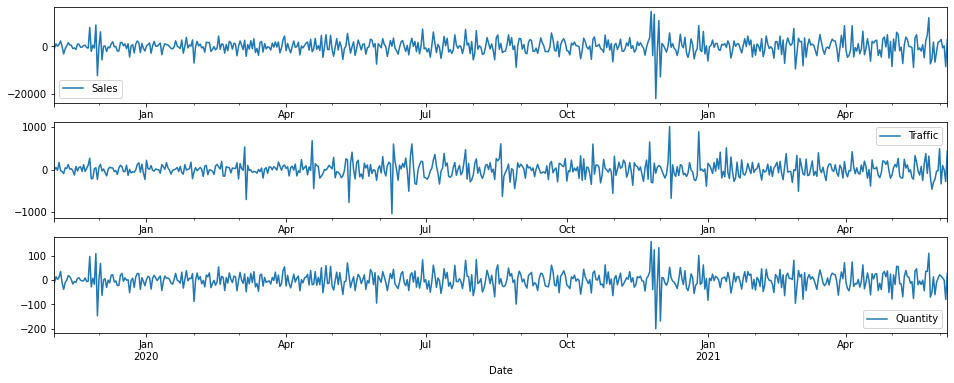

In [232]:
plt.subplot(311)
train_diff['Sales'].plot(figsize=(16, 6), legend=True)
plt.subplot(312)
train_diff['Traffic'].plot(figsize=(16, 6), legend=True)
plt.subplot(313)
train_diff['Quantity'].plot(figsize=(16, 6), legend=True)

Apply first-differencing to the test data too:

In [128]:
test_diff = test_set.diff().dropna()

# Step 5. Build and evaluate models

## 5.1 Baselines

We will create two baselines: (1) a persistence baseline and (2) a mean baseline.

### Persistence baseline

The first five observations are:

In [166]:
test_diff['Sales'].head()

Date
2021-06-08    2250.394103
2021-06-09    1046.895061
2021-06-10    -206.022660
2021-06-11     399.263525
2021-06-12   -9569.948718
Name: Sales, dtype: float64

The shift() method creates a new serie

In [167]:
test_diff['Sales'].shift().replace(np.NaN, 0.0)

Date
2021-06-08       0.000000
2021-06-09    2250.394103
2021-06-10    1046.895061
2021-06-11    -206.022660
2021-06-12     399.263525
                 ...     
2021-10-27   -1876.174041
2021-10-28    4546.486245
2021-10-29   -1242.114343
2021-10-30    1329.712831
2021-10-31   -9628.825804
Name: Sales, Length: 146, dtype: float64

So we will use latter as forecasts of the former. Because shift() creates a missing value for the first day, we will drop the first observation in both series, and then calculate an RMSE score:

In [168]:
mse = mean_squared_error(test_diff['Sales'][1:], test_diff['Sales'].shift()[1:])
np.sqrt(mse)

6844.691414810552

In [169]:
mae=mean_absolute_error(test_diff['Sales'][1:], test_diff['Sales'].shift()[1:])
mae

5226.153670758621

In [170]:
mda = get_mda(test_diff['Sales'][1:], test_diff['Sales'].shift()[1:])
mda

0.3402777777777778

In [171]:
mape=get_mape(test_diff['Sales'], test_diff['Sales'].shift()[1:])
mape

349.39852448396124

### Mean baseline

The mean baseline calculates the mean of the series in the training data and predicts the value for each test observation.

In [150]:
train_diff_mean = train_diff['Sales'].mean()
train_diff_mean

12.722513010291593

In [151]:
mse = mean_squared_error(test_diffff['Sales'], [train_diff_mean]*test_diff.shape[0])
np.sqrt(mse)

4691.7662632941165

In [152]:
mae = mean_absolute_error(test_diff['Sales'], [train_diff_mean]*test_diff.shape[0])
mae

3533.2575420197018

In [153]:
mda = get_mda(test_diff['Sales'], [train_diff_mean]*test_diff.shape[0])
mda

0.0

In [154]:
mape=get_mape(test_diff['Sales'], [train_diff_mean])
mape

99.81096986915897

## 5.2 ARIMA ($p, d, q$)

The first forecasting method we will try is [Autoregressive Integrated Moving Average ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html) (ARIMA).

### Finding $p$ and $q$ using ACF and PACF plots

We first need to determine the $p$, $d$ and $q$ parameters of the model.

We know that the $d$ (order of integration) parameter in ARIMA equals 1. 

The most common way to determine the $p$ and $q$ parameters is by using ACF and PACF plots.

In [186]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_diff['Sales'], nlags=10)
lag_pacf = pacf(train_diff['Sales'], nlags=10, method='ols')

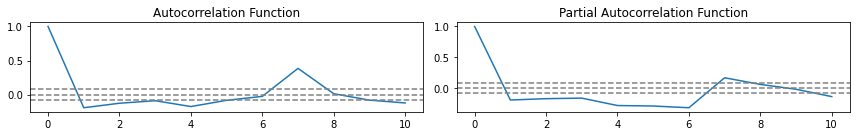

In [187]:
plt.figure(figsize=(12, 2))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

We will add **exogenous** variables into the model the values of Traffic and Quantity at lag 1:

In [188]:
exog = train_diff[['Traffic', 'Quantity']].shift().replace(np.NaN, 0.0)
exog.head(3)

,Traffic,Quantity
Date,,
2019-11-02,0.0,0.0
2019-11-03,-3.0,-9.0
2019-11-04,51.0,14.0


In [189]:
endog = train_diff['Sales']
endog.head(3)

Date
2019-11-02    -672.91
2019-11-03    1070.86
2019-11-04      73.97
Name: Sales, dtype: float64

In [192]:
from statsmodels.tsa.arima_model import ARIMA

arima = ARIMA(endog, exog=exog, order=(1, 0, 1)).fit(solver="bfgs", disp=0)

# print the significance of the variables
print(arima.summary().tables[1])

                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.0200      4.010      2.000      0.046       0.160      15.880
Traffic         3.0185      0.665      4.540      0.000       1.715       4.322
Quantity       18.4781     15.212      1.215      0.224     -11.338      48.294
ar.L1.Sales     0.2815      0.170      1.654      0.098      -0.052       0.615
ma.L1.Sales    -0.9794      0.019    -51.676      0.000      -1.017      -0.942


### Evaluate ARIMA on the test data

We can now evaluate the model on the test (out-of-sample) data. We will re-train a new model for each new instance of the test data: first we will apply the model trained on the training data to the first test instance; after recording the forecast for it, we will add the test instance to the training data, train a new model and apply it to the second test instance, and so on.

In [184]:
# buffers keeping previously seen endogenous and exogenous variables
history_endog = [x for x in endog]
history_exog = [x for x in exog.values]
predictions = []

# create exogenous variables also for the test data
test_exog = test_diff[['Traffic', 'Quantity']].shift().replace(np.NaN, 0.0)

# for each test observation, take the first 200 for convenience
for i, test_obs in enumerate(test_diff['Sales'][:200]):
    
    # build a model using the current buffers for endogenous and exogenous variables
    model = ARIMA(history_endog, exog=history_exog, order=(1, 0, 1)).fit(solver="bfgs", disp=0)
    
    # forecast the value for the test instance, supplying corresponding exogenous variables 
    yhat = model.forecast(exog=test_exog.iloc[i])[0][0]
    
    # remember the forecasted value
    predictions.append(yhat)
    
    # update the buffers for the endogenous and exogenous variables
    history_endog.append(test_obs)
    history_exog.append(test_exog.iloc[i])
    
    print('predicted=%f, expected=%f' % (yhat, test_obs))

predicted=959.551649, expected=2250.394103
predicted=-658.830154, expected=1046.895061
predicted=-904.418807, expected=-206.022660
predicted=-762.947524, expected=399.263525
predicted=-1530.997708, expected=-9569.948718
predicted=2668.969971, expected=-871.235449
predicted=3731.597343, expected=7817.691625
predicted=437.248857, expected=293.486413
predicted=327.778207, expected=3074.575846
predicted=-1552.987971, expected=1138.573947
predicted=-1867.241461, expected=-4980.333731
predicted=-472.409027, expected=-5870.638593
predicted=2861.964293, expected=3329.926669
predicted=2114.629343, expected=5162.411131
predicted=-753.210953, expected=558.169009
predicted=-885.550757, expected=567.164914
predicted=-2272.840209, expected=-2694.093301
predicted=-589.049730, expected=10179.192183
predicted=-6034.415570, expected=-10878.723750
predicted=-1000.406576, expected=2279.966277
predicted=382.230190, expected=6861.598722
predicted=-4381.790391, expected=1166.883390
predicted=-5163.576498, ex

<AxesSubplot:xlabel='Date'>

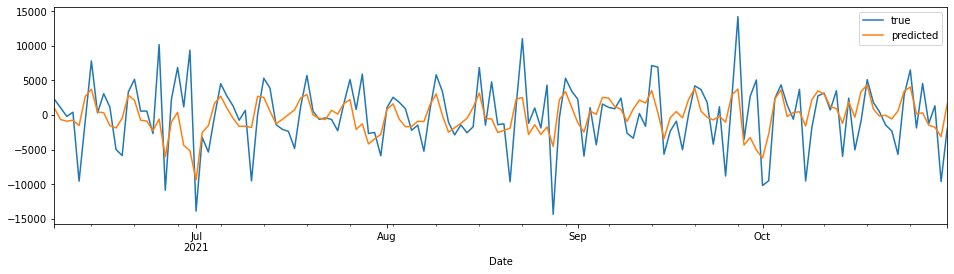

In [185]:
#plotting the predictions of ARIMA model
pd.DataFrame({"true": test_diff['Sales'][:200], "predicted": predictions}).plot(figsize=(16, 4))

In [162]:
mse = mean_squared_error(test_diff['Sales'][:200], predictions)
np.sqrt(mse)

3851.558914289196

In [163]:
mae=mean_absolute_error(test_diff['Sales'][:200], predictions)
mae

2881.7185106380334

In [164]:
mda = get_mda(test_diff['Sales'][:200], predictions)
mda

0.8137931034482758

## 5.3 Machine Learning methods

To be able to input the time series into the scikit-learn implementation of machine learning algorthms, the data needs to be arranged into a format where rows contain instances and columns contain different lagged values of both the endogenous variable and exogenous variables.

As input, the function `create_ar_vars` takes:

(1) a one-dimensional array representing the endogenous variable;

(2) a two-dimensional array representing the exogenous variable(s);

(3) the number of lags.

It outputs:

(1) a two dimensional numpy array containing predictor variables and 

(2) a one-dimensional array containing the target variable.

In [193]:
def create_ar_vars(ts_endog, ts_exog, lags=2):
    """Create autoregressive variables
    """
    dataX, dataY = [], []
    for i in range(len(ts_endog)-lags):
        endog_row = ts_endog[i:i + lags, 0]
        exog_row = ts_exog[i:i + lags,:].flatten()
        dataX.append(np.concatenate([endog_row, exog_row]))
        dataY.append(ts_endog[i + lags, 0])
    return np.array(dataX), np.array(dataY)

In [194]:
Xtrain, ytrain = create_ar_vars(ts_endog=train_diff["Sales"].values.reshape(-1, 1), 
                                ts_exog=train_diff[["Traffic", "Quantity"]].values,
                                lags=5)
Xtest, ytest = create_ar_vars(ts_endog=test_diff["Sales"].values.reshape(-1, 1),
                              ts_exog=test_diff[["Traffic", "Quantity"]].values,
                              lags=5)

In [195]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

Full training set size: 578

Split 1
Observations: 194
Training Observations: 98
Validation Observations: 96
Split 2
Observations: 290
Training Observations: 194
Validation Observations: 96
Split 3
Observations: 386
Training Observations: 290
Validation Observations: 96
Split 4
Observations: 482
Training Observations: 386
Validation Observations: 96
Split 5
Observations: 578
Training Observations: 482
Validation Observations: 96


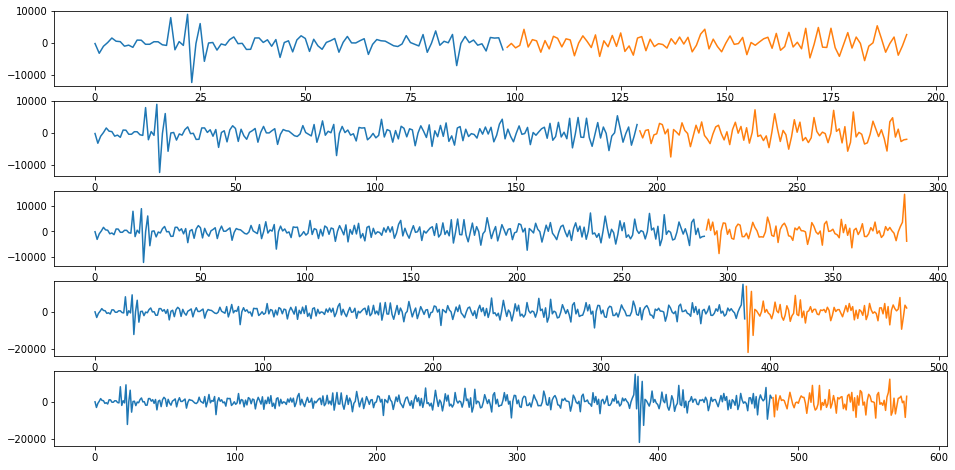

In [196]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
plt.figure(figsize=(16, 8))
plt.figure(1)
print(f"Full training set size: {Xtrain.shape[0]}\n")
index = 1
for train_index, test_index in tscv.split(Xtrain):
    train = ytrain[train_index]
    test = ytrain[test_index]
    print(f'Split {index}')
    print(f'Observations: {len(train) + len(test)}')
    print(f'Training Observations: {len(train)}')
    print(f'Validation Observations: {len(test)}')
    plt.subplot(510 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1

### Decision Tree Regression

In [281]:
dtree = DecisionTreeRegressor(random_state=7)
param_grid = [
    {'max_depth': [2, 4, 6, 8, None],
    'min_samples_split': [2, 4, 6, 8]}
]

tscv = TimeSeriesSplit(n_splits=5)
dtree_grid_search = GridSearchCV(estimator=dtree, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
dtree_grid_search.fit(Xtrain, ytrain)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 0.320 seconds


In [282]:
val_scores = dtree_grid_search.cv_results_["mean_test_score"]
train_scores = dtree_grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in dtree_grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

3489.1272526683215 2207.0091384521224 {'max_depth': 2, 'min_samples_split': 4}
3489.1272526683215 2207.0091384521224 {'max_depth': 2, 'min_samples_split': 2}
3496.137937589841 2217.5167668824774 {'max_depth': 2, 'min_samples_split': 6}
3512.603045470872 2245.760144052418 {'max_depth': 2, 'min_samples_split': 8}
3690.048447738692 1962.5766624611633 {'max_depth': 4, 'min_samples_split': 8}
3725.9311063197565 1895.964441288921 {'max_depth': 4, 'min_samples_split': 4}
3734.3427638276553 1671.8599287687746 {'max_depth': 6, 'min_samples_split': 8}
3742.9511136560236 1914.2052315445985 {'max_depth': 4, 'min_samples_split': 6}
3750.870388655485 1613.83749469694 {'max_depth': 6, 'min_samples_split': 6}
3787.4725565885833 1586.1091774382824 {'max_depth': 6, 'min_samples_split': 4}
3806.851165328842 1540.8758383831687 {'max_depth': 6, 'min_samples_split': 2}
3850.4652185509403 1419.7457175395423 {'max_depth': 8, 'min_samples_split': 8}
3856.506218605029 1864.670921418276 {'max_depth': 4, 'min_sam

In [283]:
np.sqrt(-dtree_grid_search.best_score_)

3489.1272526683215

In [284]:
dtree_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=2, random_state=7)

In [285]:
best_model = dtree_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

final_mse = mean_squared_error(ytest, yhat)
final_rmse = np.sqrt(final_mse)
final_rmse

4580.9028706390845

In [286]:
final_mae = mean_absolute_error(ytest, yhat)
final_mae

3475.375596712236

In [287]:
mda = get_mda(ytest, yhat)
mda

0.2571428571428571

<AxesSubplot:>

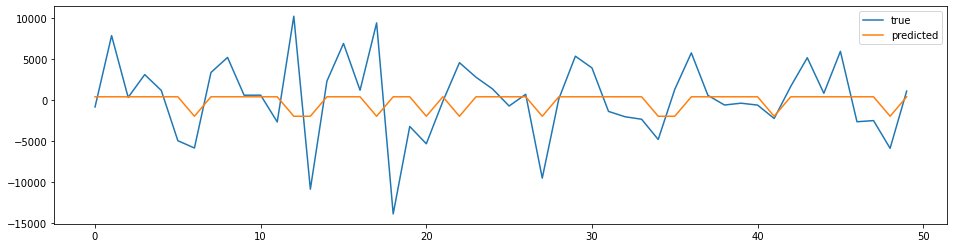

In [273]:
pd.DataFrame({"true": ytest[:50], "predicted": yhat[:50]}).plot(figsize=(16, 4))

In [293]:
dtree = DecisionTreeRegressor(random_state=7)
param_grid = [
    {'max_depth': [2, 4, 6, 8, None],
    'min_samples_split': [2, 4, 6, 8]}
]

tscv = TimeSeriesSplit(n_splits=5)
dtree_grid_search = GridSearchCV(estimator=dtree, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_absolute_error', 
                        return_train_score=True)

start = time.time()
dtree_grid_search.fit(Xtrain, ytrain)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 0.622 seconds


In [294]:
dtree_grid_search.best_estimator_

DecisionTreeRegressor(max_depth=2, random_state=7)

In [279]:
(-dtree_grid_search.best_score_)

2428.7903571558195

In [280]:
best_model = dtree_grid_search.best_estimator_

yhat = best_model.predict(Xtest)

final_mse = mean_absolute_error(ytest, yhat)
final_rmse

58.95231629641227

<AxesSubplot:>

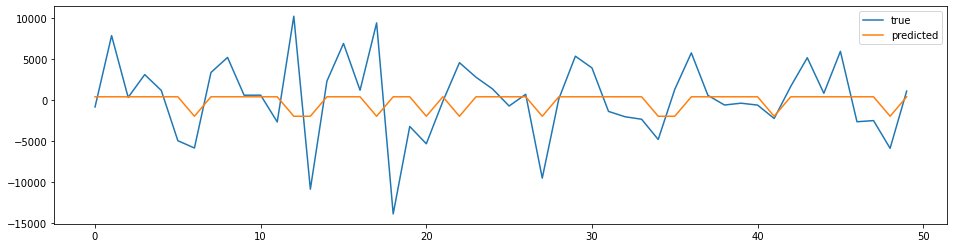

In [239]:
pd.DataFrame({"true": ytest[:50], "predicted": yhat[:50]}).plot(figsize=(16, 4))

More information on `TimeSeriesSplit` can be found in the scikit-learn [User Guide](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

Once the validation splits have been created, we can siupply the `TimeSeriesSplit` object to the grid search tool and run it to find the best hyperparameter settings in the usual way. The code below shows an example of a Random Forest regression model trained on the data.

### Random Forest

In [288]:
import time
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=7)
param_grid = [
    {'n_estimators': [2, 3, 5, 10, 20, 50], 'max_depth': [2, 4, 6, 8, None]},
]

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=forest_reg, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
grid_search.fit(Xtrain, ytrain)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 3.693 seconds


In [289]:
val_scores = grid_search.cv_results_["mean_test_score"]
train_scores = grid_search.cv_results_["mean_train_score"]
params = grid_search.cv_results_["params"]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

3110.9140106883083 1224.3847798779934 {'max_depth': 8, 'n_estimators': 50}
3115.4919971456425 923.2023177263435 {'max_depth': None, 'n_estimators': 50}
3131.166529502737 1242.5368022309872 {'max_depth': 8, 'n_estimators': 20}
3139.921861654192 1275.6924201258753 {'max_depth': 8, 'n_estimators': 10}
3150.1081547407884 962.732360672244 {'max_depth': None, 'n_estimators': 20}
3155.959156646814 1460.763920338961 {'max_depth': 6, 'n_estimators': 50}
3159.8511507302114 1502.317774874064 {'max_depth': 6, 'n_estimators': 10}
3175.922277318277 1005.2114341126119 {'max_depth': None, 'n_estimators': 10}
3185.8878594117086 1474.7307074182668 {'max_depth': 6, 'n_estimators': 20}
3189.283566618241 1760.3757181180472 {'max_depth': 4, 'n_estimators': 50}
3198.449521746817 1787.781715279359 {'max_depth': 4, 'n_estimators': 20}
3204.9225064271754 1794.3285309241285 {'max_depth': 4, 'n_estimators': 10}
3234.4712466868104 2146.300308884625 {'max_depth': 2, 'n_estimators': 20}
3235.487113471749 2132.844428

In [290]:
np.sqrt(-grid_search.best_score_)

3110.9140106883083

In [291]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=8, n_estimators=50, random_state=7)

In [292]:
best_model = grid_search.best_estimator_

yhat = best_model.predict(Xtest)

final_mse = mean_squared_error(ytest, yhat)
final_rmse = np.sqrt(final_mse)
final_rmse

3727.6738739935263

In [264]:
final_mae = mean_absolute_error(ytest, yhat)
final_mae

2744.5756221724837

<AxesSubplot:>

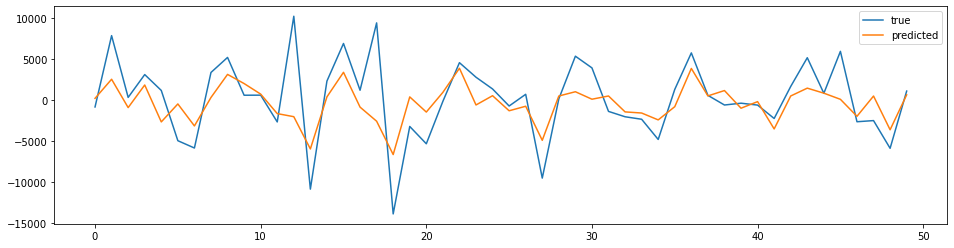

In [265]:
pd.DataFrame({"true": ytest[:50], "predicted": yhat[:50]}).plot(figsize=(16, 4))

In [266]:
mda = get_mda(ytest, yhat)
mda

0.8214285714285714

### Support Vector Regression with the RBF kernel

In [246]:
from sklearn.svm import SVR

svr = SVR(kernel="rbf")
param_grid = [
        {
            "C": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 5.0],
            "epsilon": [0.001, 0.01],
            "gamma": [0.0001, 0.001, 0.01, 0.1, "scale", "auto"]
        }
]

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=svr, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        return_train_score=True)

start = time.time()
grid_search.fit(Xtrain, ytrain)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 2.155 seconds


In [247]:
np.sqrt(-grid_search.best_score_)

3324.2312876792344

In [248]:
val_scores = grid_search.cv_results_["mean_test_score"]
train_scores = grid_search.cv_results_["mean_train_score"]
params = [str(x) for x in grid_search.cv_results_["params"]]

for val_score, train_score, param in sorted(zip(val_scores, train_scores, params), reverse=True):
    print(np.sqrt(-val_score), np.sqrt(-train_score), param)

3324.2312876792344 2613.5308152472185 {'C': 5.0, 'epsilon': 0.001, 'gamma': 'auto'}
3324.231329387755 2613.530878745142 {'C': 5.0, 'epsilon': 0.01, 'gamma': 'auto'}
3324.5098559786684 2613.313119635385 {'C': 5.0, 'epsilon': 0.001, 'gamma': 'scale'}
3324.5098906924545 2613.313176903556 {'C': 5.0, 'epsilon': 0.01, 'gamma': 'scale'}
3325.0213349109968 2613.582094854619 {'C': 5.0, 'epsilon': 0.001, 'gamma': 0.1}
3325.0213808562435 2613.5821267305014 {'C': 5.0, 'epsilon': 0.01, 'gamma': 0.1}
3329.0805064002716 2619.579114451558 {'C': 5.0, 'epsilon': 0.001, 'gamma': 0.01}
3329.0805568096575 2619.579118602791 {'C': 5.0, 'epsilon': 0.01, 'gamma': 0.01}
3331.2030272679476 2621.4615410956135 {'C': 1.0, 'epsilon': 0.001, 'gamma': 'auto'}
3331.2030462400317 2621.461560242176 {'C': 1.0, 'epsilon': 0.01, 'gamma': 'auto'}
3331.259733727887 2621.4148187218934 {'C': 1.0, 'epsilon': 0.001, 'gamma': 'scale'}
3331.259744761846 2621.414835854309 {'C': 1.0, 'epsilon': 0.01, 'gamma': 'scale'}
3331.3625421823

In [249]:
grid_search.best_estimator_

SVR(C=5.0, epsilon=0.001, gamma='auto')

In [250]:
best_model = grid_search.best_estimator_

yhat = best_model.predict(Xtest)

final_mse = mean_squared_error(ytest, yhat)
final_rmse = np.sqrt(final_mse)
final_rmse

4676.629433662218

In [252]:
final_mae = mean_absolute_error(ytest, yhat)
final_mae

3540.7495372537464

In [253]:
mda = get_mda(ytest, yhat)
mda

0.7071428571428572

<AxesSubplot:>

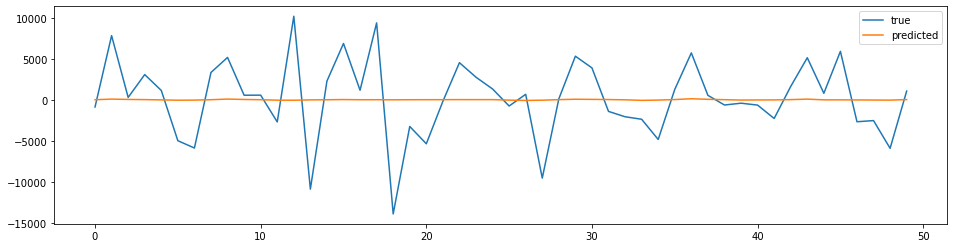

In [251]:
pd.DataFrame({"true": ytest[:50], "predicted": yhat[:50]}).plot(figsize=(16, 4))